<div><img style="float: right; width: 120px; vertical-align:rigth" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />



<h1><center>Standford Car Dataset</center></h1>

<center>Proyecto de Ciencia de Datos</center>
<center>Grado en Ciencia de Datos e Inteligencia Artificial</center>
<center>Escuela Técnica Superior de Ingeniería de Sistemas Informáticos</center>
<center>2023-2024</center>



En este proyecto se va a trabajar con el dataset de [Stanford Car Dataset](https://www.kaggle.com/datasets/jessicali9530/stanford-cars-dataset) de [Kaggle](https://www.kaggle.com/) que contiene 16.185 imágenes de 196 clases de coches. El dataset está dividido en 8.144 imágenes de entrenamiento y 8.041 imágenes de test. 

En específico, se ha optado por trabajar con el dataset de [Stanford Car Dataset by classes folder](https://www.kaggle.com/jutrera/stanford-car-dataset-by-classes-folder) que contiene las imágenes de los coches divididas en carpetas por clases *(y las clases del dataset original no están correctamente etiquetadas)*.

<span style="color:orange">**NOTA**</span>: Se recomienda el uso de GPU para la ejecución de este notebook si se desea entrenar los modelos de redes neuronales. No obstante, para una mayor facilidad de uso, se ha optado por entrenar los modelos y posteriormente guardarlos en la carpeta `models` para su posterior uso.

Dado que se está haciendo uso de GPU en Windows mediante [WSL2](https://docs.microsoft.com/en-us/windows/wsl/about) y [CUDA](https://developer.nvidia.com/cuda-zone), la siguiente celda nos permite evitar ciertos <span style="color:red">warnings</span> que aparecen al ejecutar el notebook pero que no afectan al funcionamiento del mismo.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## Import Libraries


In [2]:
import os

# Obtain current working directory
os.chdir('..')

In [41]:
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from settings import settings
from keras.utils import plot_model
from auxiliar_functions.plot_functions import plot_samples
from auxiliar_functions.perturbation import add_black_pixels

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2DTranspose, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


### Check GPU Availability

Las siguientes 3 celdas nos permiten comprobar si tenemos GPU disponible para su uso en el notebook.

In [42]:
# Check if GPU is running
print(len(tf.config.list_physical_devices('GPU')) > 0)

# See GPU devices in use
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

# Set memory growth to True. This will allow to allocate memory as needed
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Load and Visualize the Dataset

A continuación, se cargan las imágenes del dataset y se visualizan algunas de ellas. Todos los directorios que se van a utilizar en este repositorio se van a almacenar en la <span style="color:#20B2AA">**settings.py**</span> para su fácil acceso.

In [43]:
# Get train and test paths
train_path, test_path = settings.train, settings.test

# Load train and test data
train = pd.read_csv(settings.data_train, header=None)
test = pd.read_csv(settings.data_test, header=None)
train.shape, test.shape

((8144, 6), (8041, 6))

El archivo <span style="color:#20B2AA">**names.csv**</span> contiene los 196 nombres de las clases de coches que se van a utilizar en este proyecto. Se requiere un pequeño preprocesamiento para sustituir $/$ por $-$ dado que posteriormente se van a utilizar como nombres de carpetas y los $/$ ocasionan problemas.

In [44]:
# Load model names
model_names = pd.read_csv(settings.car_model, header=None)[0].tolist()

# Correct model names for them to be turned into folder name
model_names = [name.replace('/', '-') for name in model_names]

print(len(model_names), '\n', model_names[:5])

196 
 ['AM General Hummer SUV 2000', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012']


In [45]:
train.head()

,0,1,2,3,4,5
0,00001.jpg,39,116,569,375,14
1,00002.jpg,36,116,868,587,3
2,00003.jpg,85,109,601,381,91
3,00004.jpg,621,393,1484,1096,134
4,00005.jpg,14,36,133,99,106


El dataset contiene las siguientes columnas:

- La columna 0 contiene el nombre de la imagen dentro de cada carpeta.
- La columna 1 hace referencia a la coordenada `x` del punto superior izquierdo del cuadro delimitador.
- La columna 2 hace referencia a la coordenada `y` del punto superior izquierdo del cuadro delimitador.
- La columna 3 hace referencia a la coordenada `x` del punto inferior derecho del cuadro delimitador.
- La columna 4 hace referencia a la coordenada `y` del punto inferior derecho del cuadro delimitador.
- La columna 5 hace referencia a la clase del coche.

Mediante el archivo que contiene los diferentes modelos y la columna 5 del dataset, se obtiene el nombre de la clase del coche al que pertenece cada imagen.

<span style="color:orange">**NOTA**</span>: Dado que el carácter $/$ ocasiona problemas en el nombre de las carpetas, se ha optado por sustituirlo por $-$, que es la manera en la que se nomrbra a las carpetas con cada modelo.

In [46]:
# Change Column Names
train.columns = test.columns = ['img_name', 'x', 'y', 'width', 'height', 'label']
test.columns = ['img_name', 'x', 'y', 'width', 'height', 'label']

# For each item in df, find the corresponding model name
train['model'] = train.label.apply(lambda x: model_names[x-1])
test['model'] = test.label.apply(lambda x: model_names[x-1])

# Correct model names for them to be turned into folder name
train['model'] = train.model.apply(lambda x: x.replace('/', '-'))
test['model'] = test.model.apply(lambda x: x.replace('/', '-'))

In [47]:
train.head()

,img_name,x,y,width,height,label,model
0,00001.jpg,39,116,569,375,14,Audi TTS Coupe 2012
1,00002.jpg,36,116,868,587,3,Acura TL Sedan 2012
2,00003.jpg,85,109,601,381,91,Dodge Dakota Club Cab 2007
3,00004.jpg,621,393,1484,1096,134,Hyundai Sonata Hybrid Sedan 2012
4,00005.jpg,14,36,133,99,106,Ford F-450 Super Duty Crew Cab 2012


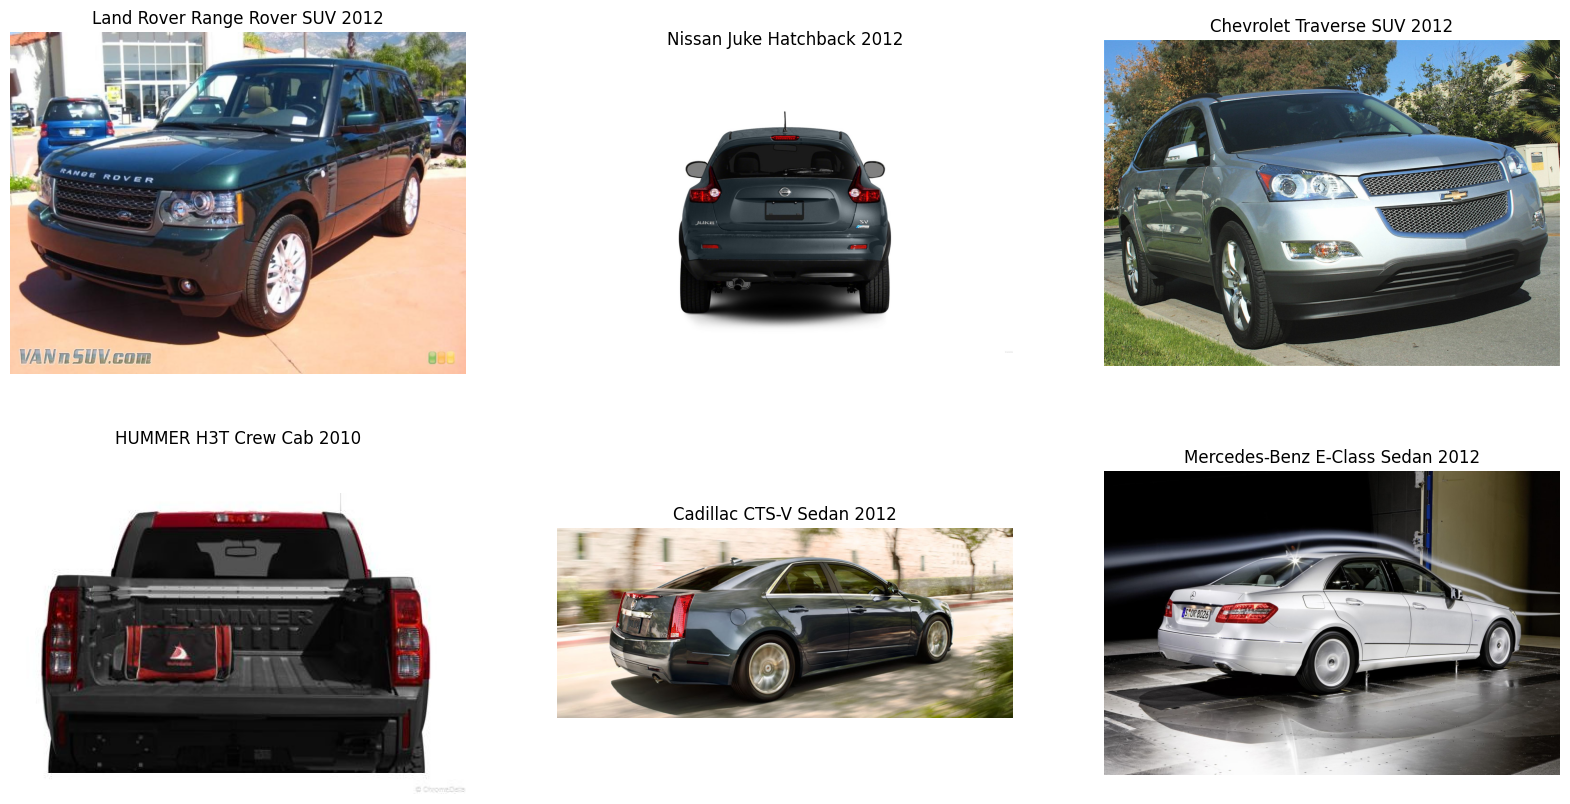

In [48]:
plot_samples(train)

In [49]:
# Check Image Sizes
sample_img = plt.imread(settings.train + train['model'][0] + '/00001.jpg')
print(f'Las dimensiones de la imagen son: {sample_img.shape}')

Las dimensiones de la imagen son: (400, 600, 3)


## Clasificación de imágenes con Ruido

In [50]:
# Clear session
tf.keras.backend.clear_session()

# Clear GPU memory
tf.compat.v1.reset_default_graph()

In [51]:
TARGET_SIZE = (128, 128)
BATCH_SIZE = 32

black_pixels = 50   # Number of black pixels to add to each image
num_classes = len(model_names)

In [52]:
# Create new train and test generators
train_datagen_black_pixels = ImageDataGenerator(rescale=1./255,
                                                preprocessing_function=lambda x: add_black_pixels(x, black_pixels))

train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen_black_pixels.flow_from_directory(train_path, 
                                                                 target_size=TARGET_SIZE, 
                                                                 batch_size=BATCH_SIZE, 
                                                                 class_mode='input',
                                                                 subset='training')

validation_generator = train_datagen.flow_from_directory(train_path,
                                                         target_size=TARGET_SIZE,
                                                         batch_size=BATCH_SIZE,
                                                         class_mode='input',
                                                         subset='validation')

test_generator = test_datagen.flow_from_directory(test_path, 
                                                  target_size=TARGET_SIZE, 
                                                  batch_size=BATCH_SIZE, 
                                                  class_mode='input')

Found 8144 images belonging to 196 classes.
Found 1546 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.


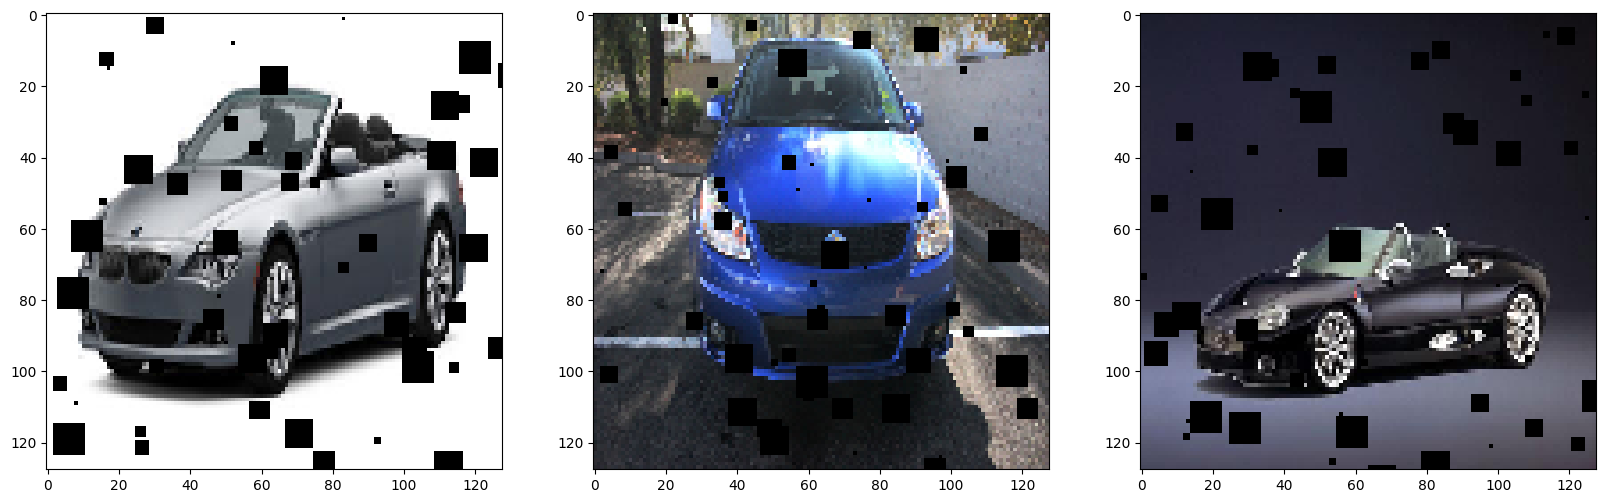

In [53]:
# Visualize SAMPLE images with black pixels

figs, axs = plt.subplots(ncols=3, figsize=(20, 10))

for i, ax in enumerate(axs.flatten()):
    x, y = train_generator.next()
    ax.imshow(x[i])

In [54]:
def Autoencoder_Model(input_shape):
    
    img_input = Input(shape=input_shape)
    
    # Encoder
    x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', strides=2)(img_input)
    x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', strides=2)(x)
    
    # Decoder
    x = Conv2DTranspose(filters=64, kernel_size=3, activation='relu', padding='same', strides=2)(x)
    x = Conv2DTranspose(filters=3, kernel_size=3, activation='sigmoid', padding='same', strides=2)(x)  
    output = x

    model = Model(inputs=img_input, outputs=output)
    
    return model

In [55]:
input_shape = TARGET_SIZE + (3,)
autoencoder = Autoencoder_Model(input_shape)

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error',
                    metrics=['accuracy'])

autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 conv2d_transpose (Conv2DTr  (None, 64, 64, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 128, 128, 3)       1731      
 Transpose)                                                      
                                                                 
Total params: 58051 (226.76 KB)
Trainable params: 58051 (226.

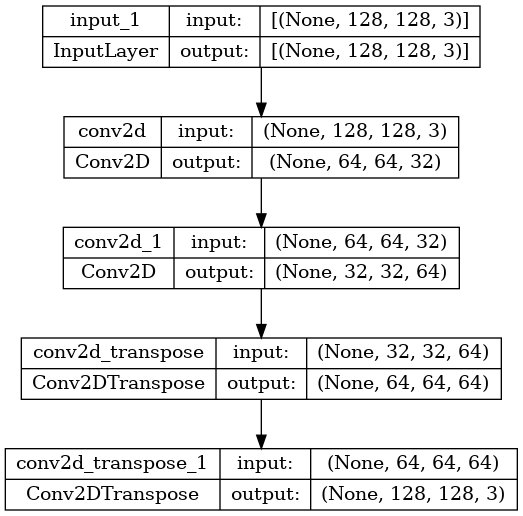

In [56]:
plot_model(autoencoder, show_shapes=True, show_layer_names=True)

In [57]:
history_path = settings.autoencoder_model + '/history.pkl'

try:
    # Open model file
    autoencoder = load_model(settings.autoencoder_model)
    print('Model loaded')
    
    # Open history file
    with open(history_path, 'rb') as file:
        history = pickle.load(file)
        
except:
    print('Model not found')
    print('Training model...')

    # Create callbacks
    checkpoint = ModelCheckpoint(settings.lenet_model, save_best_only=True, monitor='val_loss', mode='min',verbose=1)
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1)
    
    # Train model
    autoencoder_history = autoencoder.fit(train_generator,
                                          epochs=100,
                                          batch_size=128,
                                          validation_data=validation_generator,
                                          callbacks=[checkpoint, early_stopping])
    
    # Save history
    with open(history_path, 'wb') as file:
        pickle.dump(autoencoder_history, file)


Model not found
Training model...
Epoch 1/100
255/255 [==============================] - ETA: 0s - loss: 0.0258 - accuracy: 0.4773
Epoch 1: val_loss improved from inf to 0.00803, saving model to models/checkpoints/lenet.ckpt
INFO:tensorflow:Assets written to: models/checkpoints/lenet.ckpt/assets


INFO:tensorflow:Assets written to: models/checkpoints/lenet.ckpt/assets


255/255 [==============================] - 117s 449ms/step - loss: 0.0258 - accuracy: 0.4773 - val_loss: 0.0080 - val_accuracy: 0.6425
Epoch 2/100
255/255 [==============================] - ETA: 0s - loss: 0.0082 - accuracy: 0.6307
Epoch 2: val_loss improved from 0.00803 to 0.00665, saving model to models/checkpoints/lenet.ckpt
INFO:tensorflow:Assets written to: models/checkpoints/lenet.ckpt/assets


INFO:tensorflow:Assets written to: models/checkpoints/lenet.ckpt/assets


255/255 [==============================] - 94s 369ms/step - loss: 0.0082 - accuracy: 0.6307 - val_loss: 0.0066 - val_accuracy: 0.6726
Epoch 3/100
255/255 [==============================] - ETA: 0s - loss: 0.0060 - accuracy: 0.6415
Epoch 3: val_loss improved from 0.00665 to 0.00457, saving model to models/checkpoints/lenet.ckpt
INFO:tensorflow:Assets written to: models/checkpoints/lenet.ckpt/assets


INFO:tensorflow:Assets written to: models/checkpoints/lenet.ckpt/assets


255/255 [==============================] - 93s 365ms/step - loss: 0.0060 - accuracy: 0.6415 - val_loss: 0.0046 - val_accuracy: 0.6838
Epoch 4/100
255/255 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 0.6686
Epoch 4: val_loss improved from 0.00457 to 0.00363, saving model to models/checkpoints/lenet.ckpt
INFO:tensorflow:Assets written to: models/checkpoints/lenet.ckpt/assets


INFO:tensorflow:Assets written to: models/checkpoints/lenet.ckpt/assets


255/255 [==============================] - 84s 330ms/step - loss: 0.0047 - accuracy: 0.6686 - val_loss: 0.0036 - val_accuracy: 0.7052
Epoch 5/100
 73/255 [=======>......................] - ETA: 50s - loss: 0.0039 - accuracy: 0.6808

In [ ]:
# Visualize autoencoder results
x, y = train_generator.next()

# Class labels
class_labels = train_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}

figs, axs = plt.subplots(ncols=4, figsize=(20, 10))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(autoencoder.predict(x)[i])
    ax.set_title(class_labels[np.argmax(y[i])])
    ax.axis('off')              